# 하이브리드 머신러닝 모델 (khj + kys)

## 목표
- 판매량 기반 차등 임계값 타겟 정의 + kys의 풍부한 피처
  - Group A (상위 25%): 75% 분위수 (관대)
  - Group B (25.1~50%): 90% 분위수 (엄격)
- 9개 피처: khj 2개 + kys 5개 + 상호작용 2개
- 10-Fold CV + Train/Test Split 이중 평가
- Threshold 최적화 (Recall >= 0.6)
- 메일링 시스템(kys_Mailing.py) 호환 CSV 생성

## 출력
- `kys/Result/risk_report_result.csv` (seller_id, y_pred_proba, 주요_위험사유)


---
## 1. 라이브러리 임포트


In [660]:
import pandas as pd
import numpy as np
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (StratifiedKFold, cross_validate, 
                                    train_test_split)
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score,
                             accuracy_score)
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

#한글 폰트 설정
plt.rcParams['font.family'] = 'Noto Sans KR'
plt.rcParams['axes.unicode_minus'] = False



---
## 2. 데이터 로드 및 필터링


In [661]:
df_raw = pd.read_csv('../Olist_DataSet/merged_olist.csv')

In [662]:
# 필터링 로직: 물류사 과실이더라도 판매자 과실이 있으면 포함
# is_logistics_fault == False: 물류사 과실 아님
# seller_delay_days > 0: 판매자가 shipping_limit_date 초과 (판매자 과실)

df = df_raw[
    (df_raw['is_logistics_fault'] == False) | 
    (df_raw['seller_delay_days'] > 0)         
].copy()

print("="*80)
print("데이터 필터링 결과")
print("="*80)
print(f"전체 데이터: {len(df_raw):,}건")
print(f"물류사 과실: {(df_raw['is_logistics_fault']==True).sum():,}건")
print(f"판매자 과실: {(df_raw['seller_delay_days']>0).sum():,}건")
print(f"양쪽 모두 과실: {((df_raw['is_logistics_fault']==True) & (df_raw['seller_delay_days']>0)).sum():,}건")
print(f"\n필터링 후: {len(df):,}건")
print(f"제외된 건수: {len(df_raw) - len(df):,}건 (순수 물류사 과실만 제외)")


데이터 필터링 결과
전체 데이터: 64,850건
물류사 과실: 2,464건
판매자 과실: 5,535건
양쪽 모두 과실: 1,050건

필터링 후: 63,436건
제외된 건수: 1,414건 (순수 물류사 과실만 제외)


---
## 3. 기본 전처리


In [663]:
# prep_time 계산
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['prep_time'] = (
    df['order_delivered_carrier_date'] - df['order_approved_at']
).dt.total_seconds() / 86400

print("prep_time 계산 완료")
print(f"평균 prep_time: {df['prep_time'].mean():.2f}일")


prep_time 계산 완료
평균 prep_time: 2.71일


In [664]:
# 텍스트 리뷰에서 지연 키워드 추출
delay_keywords = ['atraso', 'demora', 'lento', 'esperar', 'prazo', 'não recebi', 'nao recebi', 'cadê', 'cade', 'entrega',
    'atraso', 'chegou', 'ainda não', 'ainda nao', 'onde está']

df['has_delay_comment'] = df['review_comment_message'].fillna('').apply(
    lambda x: 1 if any(word in x.lower() for word in delay_keywords) else 0
)

print("지연 키워드 추출 완료")
print(f"지연 키워드 포함 리뷰: {df['has_delay_comment'].sum():,}건 ({df['has_delay_comment'].mean()*100:.2f}%)")


지연 키워드 추출 완료
지연 키워드 포함 리뷰: 10,810건 (17.04%)


In [665]:
# 이진 변수 생성
df['is_processing_delayed'] = (df['processing_days_diff'] > 0).astype(int)
df['is_seller_delayed'] = (df['seller_delay_days'] > 0).astype(int)
df['is_negative_review'] = (df['review_score'] <= 3).astype(int)
df['is_critical_complaint'] = (
    (df['review_score'] <= 3) & (df['has_text_review'] == True)
).astype(int)

print("이진 변수 생성 완료")
print(f"처리지연: {df['is_processing_delayed'].sum():,}건 ({df['is_processing_delayed'].mean()*100:.1f}%)")
print(f"출고지연: {df['is_seller_delayed'].sum():,}건 ({df['is_seller_delayed'].mean()*100:.1f}%)")
print(f"부정리뷰: {df['is_negative_review'].sum():,}건 ({df['is_negative_review'].mean()*100:.1f}%)")
print(f"심각불만: {df['is_critical_complaint'].sum():,}건 ({df['is_critical_complaint'].mean()*100:.1f}%)")


이진 변수 생성 완료
처리지연: 22,058건 (34.8%)
출고지연: 5,535건 (8.7%)
부정리뷰: 12,332건 (19.4%)
심각불만: 8,202건 (12.9%)


---
## 4. 판매자별 집계


In [666]:
# 판매자별 집계 (시계열 없음)
seller_stats = df.groupby('seller_id').agg({
    'has_delay_comment': 'mean',              # text_review_ratio
    'order_id': 'nunique',                    # order_count
    'is_processing_delayed': 'mean',          # processing_delay_rate
    'is_seller_delayed': 'mean',              # seller_delay_rate
    'is_negative_review': 'mean',             # negative_review_rate
    'is_critical_complaint': 'mean',          # critical_complaint_rate
    'seller_processing_days': ['mean', 'std'] # processing_days_mean/std
}).reset_index()

# 컬럼명 정리
seller_stats.columns = [
    'seller_id',
    'text_review_ratio',
    'order_count',
    'processing_delay_rate',
    'seller_delay_rate',
    'negative_review_rate',
    'critical_complaint_rate',
    'processing_days_mean',
    'processing_days_std'
]

# NaN 처리
seller_stats = seller_stats.fillna(0)

print("="*80)
print("판매자별 집계 완료")
print("="*80)
print(f"판매자 수: {len(seller_stats):,}명")
print(f"\n[피처별 평균]")
print(f"  text_review_ratio:      {seller_stats['text_review_ratio'].mean():.4f}")
print(f"  order_count:            {seller_stats['order_count'].mean():.1f}")
print(f"  processing_delay_rate:  {seller_stats['processing_delay_rate'].mean():.4f}")
print(f"  seller_delay_rate:      {seller_stats['seller_delay_rate'].mean():.4f}")
print(f"  negative_review_rate:   {seller_stats['negative_review_rate'].mean():.4f}")


판매자별 집계 완료
판매자 수: 2,661명

[피처별 평균]
  text_review_ratio:      0.1719
  order_count:            21.1
  processing_delay_rate:  0.3691
  seller_delay_rate:      0.1115
  negative_review_rate:   0.1801


---
## 5. 피처 엔지니어링 (상호작용 2개 추가)


In [667]:
# 상호작용 피처 생성 (2개)
seller_stats['delay_negative_interaction'] = (
    seller_stats['seller_delay_rate'] * seller_stats['negative_review_rate']
)

seller_stats['processing_seller_delay_interaction'] = (
    seller_stats['processing_delay_rate'] * seller_stats['seller_delay_rate']
)

print("상호작용 피처 생성 완료")
print(f"총 피처 수: 9개")
print("\n[9개 피처 구성]")
print("  khj (2개): text_review_ratio, order_count")
print("  kys (5개): processing_delay_rate, negative_review_rate,")
print("            critical_complaint_rate, processing_days_mean, processing_days_std")
print("  상호작용 (2개): delay_negative_interaction, processing_seller_delay_interaction")


상호작용 피처 생성 완료
총 피처 수: 9개

[9개 피처 구성]
  khj (2개): text_review_ratio, order_count
  kys (5개): processing_delay_rate, negative_review_rate,
            critical_complaint_rate, processing_days_mean, processing_days_std
  상호작용 (2개): delay_negative_interaction, processing_seller_delay_interaction


---
## 5.5 피처 상관관계 분석

9개 피처 간의 상관관계를 분석하여 다중공선성 확인


In [668]:
# 9개 피처 상관관계 히트맵
correlation_features = [
    # khj (2개)
    'text_review_ratio', 'order_count',
    # kys 기본 (5개)
    'processing_delay_rate', 'negative_review_rate',
    'critical_complaint_rate', 'processing_days_mean', 'processing_days_std',
    # 상호작용 (2개)
    'delay_negative_interaction', 'processing_seller_delay_interaction'
]

# 상관관계 계산
corr_matrix = seller_stats[correlation_features].corr()


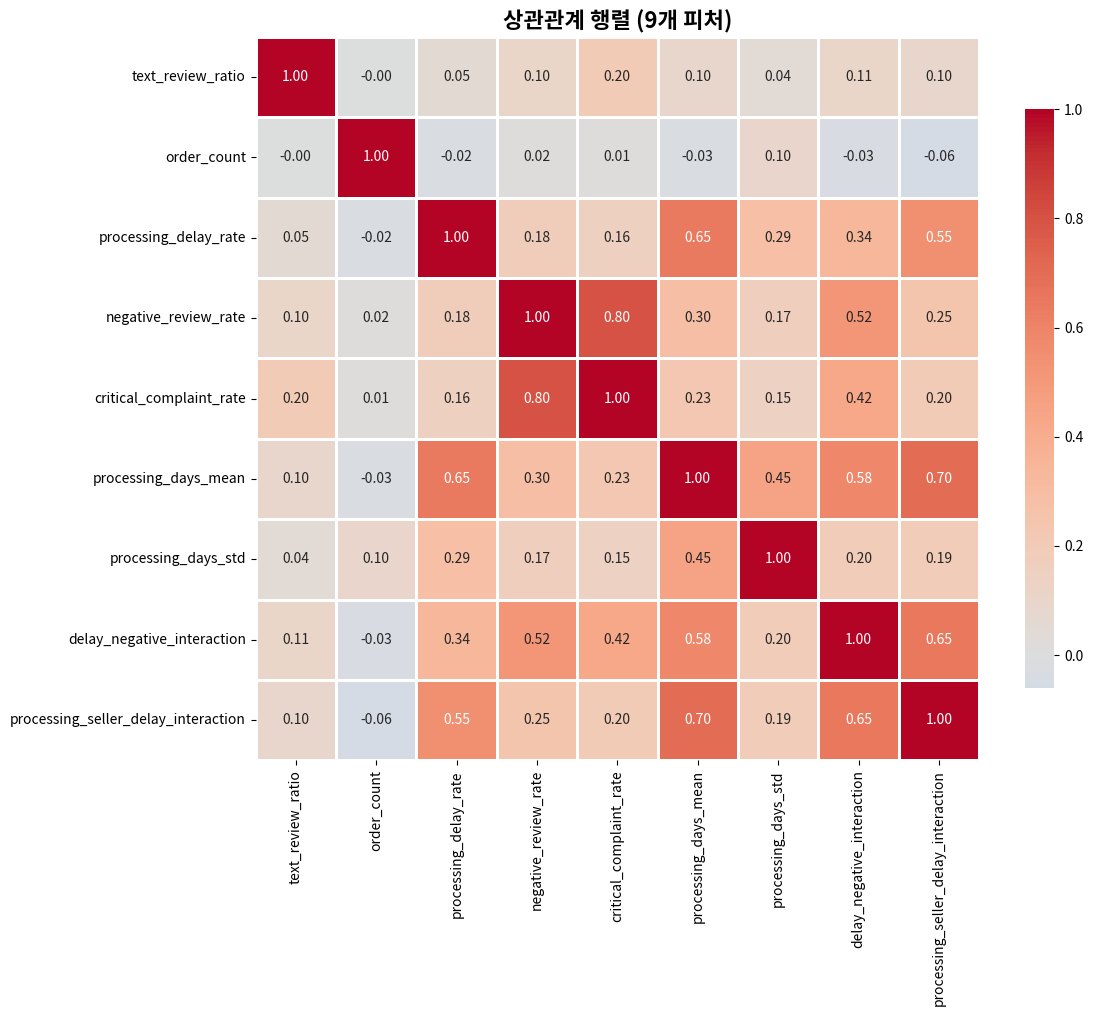

In [669]:
# 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('상관관계 행렬 (9개 피처)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [670]:
# 강한 상관관계 추출 (절댓값 0.7 이상)
threshold = 0.7
high_corr = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) >= threshold:
            high_corr.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

if len(high_corr) > 0:
    df_high_corr = pd.DataFrame(high_corr).sort_values('Correlation', 
                                                        key=abs, 
                                                        ascending=False)
    print("="*80)
    print(f"강한 상관관계 (|r| >= {threshold})")
    print("="*80)
    print(df_high_corr.to_string(index=False))
    print(f"\n총 {len(df_high_corr)}쌍의 강한 상관관계 발견")
else:
    print(f"강한 상관관계 (|r| >= {threshold})를 가진 피처 쌍이 없습니다.")


강한 상관관계 (|r| >= 0.7)
           Feature 1               Feature 2  Correlation
negative_review_rate critical_complaint_rate     0.798723

총 1쌍의 강한 상관관계 발견


In [671]:
# VIF (Variance Inflation Factor) - 다중공선성 검사
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF 계산
X_for_vif = seller_stats[correlation_features].fillna(0)
vif_data = pd.DataFrame()
vif_data['Feature'] = correlation_features
vif_data['VIF'] = [variance_inflation_factor(X_for_vif.values, i) 
                    for i in range(len(correlation_features))]
vif_data = vif_data.sort_values('VIF', ascending=False)

print("="*80)
print("다중공선성 검사")
print("="*80)
print(vif_data.to_string(index=False))

# VIF 통계
low_vif = (vif_data['VIF'] < 5).sum()
mid_vif = ((vif_data['VIF'] >= 5) & (vif_data['VIF'] <= 10)).sum()
high_vif = (vif_data['VIF'] > 10).sum()

print(f"\n[VIF 분포]")
print(f"  VIF < 5:   {low_vif}개 피처")
print(f"  VIF 5-10:  {mid_vif}개 피처")
print(f"  VIF > 10:  {high_vif}개 피처")

print("\n" + "-"*80)
print("참고:")
print("  - seller_delay_rate는 타겟 정의와 위험사유 생성용으로만 사용")
print("  - 모델 피처로는 제외되었지만 상호작용 피처 생성에 활용됨")
print("-"*80)


다중공선성 검사
                            Feature      VIF
               processing_days_mean 5.502356
               negative_review_rate 4.599031
            critical_complaint_rate 3.827381
              processing_delay_rate 3.444140
processing_seller_delay_interaction 2.981963
         delay_negative_interaction 2.450185
                processing_days_std 2.142832
                  text_review_ratio 1.439309
                        order_count 1.111339

[VIF 분포]
  VIF < 5:   8개 피처
  VIF 5-10:  1개 피처
  VIF > 10:  0개 피처

--------------------------------------------------------------------------------
참고:
  - seller_delay_rate는 타겟 정의와 위험사유 생성용으로만 사용
  - 모델 피처로는 제외되었지만 상호작용 피처 생성에 활용됨
--------------------------------------------------------------------------------


---
## 상관관계 분석 인사이트 요약

### 1. 상호작용 피처의 특성 (2개)
- `delay_negative_interaction`: seller_delay_rate × negative_review_rate
- `processing_seller_delay_interaction`: processing_delay_rate × seller_delay_rate
- 상호작용 피처는 원본 피처의 곱셈 조합으로 비선형 관계 포착

### 2. RandomForest 모델에서의 영향
- Tree 기반 모델은 다중공선성에 강인함
- 높은 상관관계가 있어도 예측 성능에는 큰 영향 없음
- 각 트리가 피처를 무작위로 선택하므로 상관관계 문제 완화

### 3. 모델 선택 시 고려사항
**선형 모델(Linear/Logistic Regression) 사용 시**
- 상호작용 피처 제거 고려 필요
- 또는 원본 피처만 사용

### 4. 피처 해석
- 피처 중요도 분석 시 상관관계 고려 필요
- 상관관계가 높은 피처들은 중요도가 분산될 수 있음
- 비즈니스 해석

---
## 6. 타겟 정의 (판매량 기반 차등 임계값)

### 비즈니스 로직
- **Group A (상위 25%)**: 초대형 판매자 → 75% 분위수
- **Group B (25.1~50%)**: 중대형 판매자 → 90% 분위수


In [672]:
# Group A: 상위 25% (초대형 판매자) - 75% 분위수 임계값
quantile_25 = seller_stats['order_count'].quantile(0.75) 
group_a = seller_stats[seller_stats['order_count'] >= quantile_25].copy()

thresholds_a = {
    'processing_delay_rate': group_a['processing_delay_rate'].quantile(0.75),
    'seller_delay_rate': group_a['seller_delay_rate'].quantile(0.75),
    'negative_review_rate': group_a['negative_review_rate'].quantile(0.75)
}

group_a['is_Seller_of_Note'] = (
    (group_a['processing_delay_rate'] >= thresholds_a['processing_delay_rate']) &
    (group_a['seller_delay_rate'] >= thresholds_a['seller_delay_rate']) &
    (group_a['negative_review_rate'] >= thresholds_a['negative_review_rate'])
).astype(int)

print("\n[Group A - 상위 25% 판매자, 75% 분위수 기준]")
print(f"  판매자 수: {len(group_a):,}명")
print(f"  주문 범위: {group_a['order_count'].min():.0f}~{group_a['order_count'].max():.0f}건")
print(f"  processing_delay_rate >= {thresholds_a['processing_delay_rate']:.4f}")
print(f"  seller_delay_rate     >= {thresholds_a['seller_delay_rate']:.4f}")
print(f"  negative_review_rate  >= {thresholds_a['negative_review_rate']:.4f}")
print(f"  유의 판매자: {group_a['is_Seller_of_Note'].sum()}명 ({group_a['is_Seller_of_Note'].mean()*100:.1f}%)")



[Group A - 상위 25% 판매자, 75% 분위수 기준]
  판매자 수: 671명
  주문 범위: 16~1044건
  processing_delay_rate >= 0.4762
  seller_delay_rate     >= 0.1180
  negative_review_rate  >= 0.2458
  유의 판매자: 60명 (8.9%)


In [673]:
# Group B: 상위 25~50% (중대형 판매자) - 90% 분위수 임계값
quantile_50 = seller_stats['order_count'].quantile(0.50) 
group_b = seller_stats[
    (seller_stats['order_count'] >= quantile_50) & 
    (seller_stats['order_count'] < quantile_25)
].copy()

thresholds_b = {
    'processing_delay_rate': group_b['processing_delay_rate'].quantile(0.90),
    'seller_delay_rate': group_b['seller_delay_rate'].quantile(0.90),
    'negative_review_rate': group_b['negative_review_rate'].quantile(0.90)
}

group_b['is_Seller_of_Note'] = (
    (group_b['processing_delay_rate'] >= thresholds_b['processing_delay_rate']) &
    (group_b['seller_delay_rate'] >= thresholds_b['seller_delay_rate']) &
    (group_b['negative_review_rate'] >= thresholds_b['negative_review_rate'])
).astype(int)

print("\n[Group B - 상위 25.1~50% 판매자, 90% 분위수 기준]")
print(f"  판매자 수: {len(group_b):,}명")
print(f"  주문 범위: {group_b['order_count'].min():.0f}~{group_b['order_count'].max():.0f}건")
print(f"  processing_delay_rate >= {thresholds_b['processing_delay_rate']:.4f}")
print(f"  seller_delay_rate     >= {thresholds_b['seller_delay_rate']:.4f}")
print(f"  negative_review_rate  >= {thresholds_b['negative_review_rate']:.4f}")
print(f"  유의 판매자: {group_b['is_Seller_of_Note'].sum()}명 ({group_b['is_Seller_of_Note'].mean()*100:.1f}%)")



[Group B - 상위 25.1~50% 판매자, 90% 분위수 기준]
  판매자 수: 749명
  주문 범위: 5~15건
  processing_delay_rate >= 0.8000
  seller_delay_rate     >= 0.3167
  negative_review_rate  >= 0.4000
  유의 판매자: 14명 (1.9%)


In [674]:
# 그룹 병합
df_final = pd.concat([group_a, group_b])

print("\n" + "="*80)
print("최종 데이터셋")
print("="*80)
print(f"총 판매자: {len(df_final):,}명")
print(f"유의 판매자: {df_final['is_Seller_of_Note'].sum():,}명 ({df_final['is_Seller_of_Note'].mean()*100:.1f}%)")
print(f"정상 판매자: {(df_final['is_Seller_of_Note']==0).sum():,}명 ({(df_final['is_Seller_of_Note']==0).mean()*100:.1f}%)")



최종 데이터셋
총 판매자: 1,420명
유의 판매자: 74명 (5.2%)
정상 판매자: 1,346명 (94.8%)


---
## 7. 모델 학습 및 이중 평가


In [675]:
# 피처와 타겟 준비
feature_7 = [
    'negative_review_rate',        
    'text_review_ratio',           
    'critical_complaint_rate',     
    'processing_delay_rate',        
    'processing_days_mean',        
    'processing_days_std',         
    'order_count'     
]

X = df_final[feature_7].fillna(0)
y = df_final['is_Seller_of_Note']

print("="*80)
print("피처 및 타겟 준비 완료")
print("="*80)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"피처 수: {len(feature_7)}개")


피처 및 타겟 준비 완료
X shape: (1420, 7)
y shape: (1420,)
피처 수: 7개


In [676]:
# RandomForest 모델 설정
model = RandomForestClassifier(
    n_estimators=200,        
    max_depth=8,            
    min_samples_leaf=8,      
    min_samples_split=6,     
    class_weight='balanced',
    random_state=42
)

In [677]:
# 평가 2: Train/Test Split (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("\n" + "="*80)
print("평가 2: Train/Test Split (80:20)")
print("="*80)
print(f"Train: {len(X_train):,}건 ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test:  {len(X_test):,}건 ({len(X_test)/len(X)*100:.1f}%)")
print(f"\n[Train Target 분포]")
print(f"  정상: {(y_train==0).sum():,}건 ({(y_train==0).mean()*100:.1f}%)")
print(f"  유의: {(y_train==1).sum():,}건 ({(y_train==1).mean()*100:.1f}%)")
print(f"\n[Test Target 분포]")
print(f"  정상: {(y_test==0).sum():,}건 ({(y_test==0).mean()*100:.1f}%)")
print(f"  유의: {(y_test==1).sum():,}건 ({(y_test==1).mean()*100:.1f}%)")



평가 2: Train/Test Split (80:20)
Train: 994건 (70.0%)
Test:  426건 (30.0%)

[Train Target 분포]
  정상: 942건 (94.8%)
  유의: 52건 (5.2%)

[Test Target 분포]
  정상: 404건 (94.8%)
  유의: 22건 (5.2%)


In [678]:
# 모델 학습 및 기본 예측 (threshold=0.5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [679]:
# Confusion Matrix 및 Classification Report (threshold=0.5)
cm = confusion_matrix(y_test, y_pred)

print("\n" + "="*80)
print("기본 성능 평가 (Threshold=0.5)")
print("="*80)
print("\n[Confusion Matrix]")
print(f"  TN={cm[0,0]:,}  FP={cm[0,1]:,}")
print(f"  FN={cm[1,0]:,}  TP={cm[1,1]:,}")

print("\n[Classification Report]")
print(classification_report(y_test, y_pred, target_names=['정상', '유의 판매자']))



기본 성능 평가 (Threshold=0.5)

[Confusion Matrix]
  TN=396  FP=8
  FN=1  TP=21

[Classification Report]
              precision    recall  f1-score   support

          정상       1.00      0.98      0.99       404
      유의 판매자       0.72      0.95      0.82        22

    accuracy                           0.98       426
   macro avg       0.86      0.97      0.91       426
weighted avg       0.98      0.98      0.98       426



In [680]:
# 5-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 여러 메트릭으로 평가
scoring = ['precision', 'recall', 'f1', 'roc_auc']
cv_results = cross_validate(model, X, y, 
                            cv=skf, 
                            scoring=scoring,
                            return_train_score=True)

print("="*80)
print("평가2 : 5-Fold 교차 검증 결과 (Train vs Test 비교)")
print("="*80)
for metric in scoring:
    train_mean = cv_results[f'train_{metric}'].mean()
    test_mean = cv_results[f'test_{metric}'].mean()
    diff = train_mean - test_mean
    
    print(f"{metric:12s}: Train={train_mean:.4f}, Test={test_mean:.4f}, "
          f"Diff={diff:.4f} {'과적합' if diff > 0.1 else '적합'}")

평가2 : 5-Fold 교차 검증 결과 (Train vs Test 비교)
precision   : Train=0.7316, Test=0.6655, Diff=0.0662 적합
recall      : Train=1.0000, Test=0.9067, Diff=0.0933 적합
f1          : Train=0.8448, Test=0.7651, Diff=0.0797 적합
roc_auc     : Train=0.9983, Test=0.9939, Diff=0.0044 적합


---
## 8. Threshold 최적화


In [681]:
# Threshold 탐색
thresholds = np.arange(0.3, 0.8, 0.05)
results = []

for threshold in thresholds:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    prec = precision_score(y_test, y_pred_thresh, zero_division=0)
    rec = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    results.append({'threshold': threshold, 'precision': prec, 'recall': rec, 'f1_score': f1})

df_thresh = pd.DataFrame(results)

print("="*80)
print("Threshold별 성능")
print("="*80)
print(df_thresh.round(4).to_string(index=False))


Threshold별 성능
 threshold  precision  recall  f1_score
      0.30     0.5500  1.0000    0.7097
      0.35     0.5641  1.0000    0.7213
      0.40     0.6111  1.0000    0.7586
      0.45     0.6176  0.9545    0.7500
      0.50     0.7241  0.9545    0.8235
      0.55     0.7778  0.9545    0.8571
      0.60     0.8077  0.9545    0.8750
      0.65     0.8696  0.9091    0.8889
      0.70     0.9091  0.9091    0.9091
      0.75     0.9444  0.7727    0.8500


In [682]:
# 최적 threshold로 재평가
y_pred_optimal = (y_proba >= 0.7).astype(int)
cm_optimal = confusion_matrix(y_test, y_pred_optimal)

print("\n" + "="*80)
print(f"최적 Threshold ({0.7:.2f}) 적용 결과")
print("="*80)
print("\n[Confusion Matrix]")
print(f"  TN={cm_optimal[0,0]:,}  FP={cm_optimal[0,1]:,}")
print(f"  FN={cm_optimal[1,0]:,}  TP={cm_optimal[1,1]:,}")

print("\n[Classification Report]")
print(classification_report(y_test, y_pred_optimal, target_names=['정상', '유의 판매자']))



최적 Threshold (0.70) 적용 결과

[Confusion Matrix]
  TN=402  FP=2
  FN=2  TP=20

[Classification Report]
              precision    recall  f1-score   support

          정상       1.00      1.00      1.00       404
      유의 판매자       0.91      0.91      0.91        22

    accuracy                           0.99       426
   macro avg       0.95      0.95      0.95       426
weighted avg       0.99      0.99      0.99       426



---
## 9. 전체 판매자 예측 및 위험사유 생성


In [683]:
# 전체 데이터로 모델 재학습
model.fit(X, y)

# 전체 판매자 예측
df_final['y_pred_proba'] = model.predict_proba(X)[:, 1]

print("="*80)
print("전체 판매자 예측 완료")
print("="*80)
print(f"전체 판매자: {len(df_final):,}명")
print(f"평균 위험 확률: {df_final['y_pred_proba'].mean():.4f}")
print(f"최소/최대 위험 확률: {df_final['y_pred_proba'].min():.4f} / {df_final['y_pred_proba'].max():.4f}")


전체 판매자 예측 완료
전체 판매자: 1,420명
평균 위험 확률: 0.0814
최소/최대 위험 확률: 0.0000 / 0.9965


In [684]:
# 위험사유 생성 함수
def get_main_reason(row):
    reasons = []
    
    # 기본 지표
    if row['processing_delay_rate'] >= 0.5:
        reasons.append(f"처리지연율 높음({row['processing_delay_rate']*100:.0f}%)")
    if row['seller_delay_rate'] >= 0.5:
        reasons.append(f"출고지연율 높음({row['seller_delay_rate']*100:.0f}%)")
    if row['negative_review_rate'] >= 0.3:
        reasons.append(f"부정리뷰율 높음({row['negative_review_rate']*100:.0f}%)")
    
    # khj 피처
    if row['text_review_ratio'] > 0.05:
        reasons.append(f"지연 불만 리뷰 다수({row['text_review_ratio']*100:.0f}%)")
    
    return " | ".join(reasons) if reasons else "복합 지표 위험"

# 위험사유 적용
df_final['주요_위험사유'] = df_final.apply(get_main_reason, axis=1)

print("위험사유 생성 완료")
print(f"\n[위험사유 샘플]")
print(df_final[['seller_id', 'y_pred_proba', '주요_위험사유']].head(10).to_string(index=False))


위험사유 생성 완료

[위험사유 샘플]
                       seller_id  y_pred_proba          주요_위험사유
001cca7ae9ae17fb1caed9dfb1094831      0.013151 지연 불만 리뷰 다수(28%)
004c9cd9d87a3c30c522c48c4fc07416      0.000000 지연 불만 리뷰 다수(14%)
00ee68308b45bc5e2660cd833c3f81cc      0.000000 지연 불만 리뷰 다수(20%)
00fc707aaaad2d31347cf883cd2dfe10      0.003345 지연 불만 리뷰 다수(23%)
0176f73cc1195f367f7b32db1e5b3aa8      0.000000 지연 불만 리뷰 다수(16%)
01cf7e3d21494c41fb86034f2e714fa1      0.000000 지연 불만 리뷰 다수(19%)
01fd077212124329bac32490e8ef80d9      0.000000 지연 불만 리뷰 다수(17%)
01fdefa7697d26ad920e9e0346d4bd1b      0.000000 지연 불만 리뷰 다수(17%)
0241d4d5d36f10f80c644447315af0bd      0.000000 지연 불만 리뷰 다수(17%)
02f623a8eb246f3c5f7c2f96462654e6      0.000000  지연 불만 리뷰 다수(9%)


---
## 10. 메일링 시스템 호환 CSV 생성


In [685]:
# 전체 판매자 포함 (메일링 시스템에서 4단계 자동 분류)
output_df = df_final[[
    'seller_id',
    'y_pred_proba',
    '주요_위험사유'
]].copy()

# 위험도 순 정렬
output_df = output_df.sort_values('y_pred_proba', ascending=False)

# CSV 저장 (메일링 시스템이 읽을 파일)
output_path = '../Result/risk_report_result.csv'
output_df.to_csv(output_path, index=False, encoding='utf-8-sig')

print("="*80)
print("메일링 시스템 호환 CSV 생성 완료")
print("="*80)
print(f"저장 경로: {output_path}")
print(f"전체 판매자: {len(output_df):,}명")

# 메일링 시스템의 4단계 분류 기준으로 통계
print(f"\n[예상 메일링 분류 (y_pred_proba 기준)]")
print(f"  RED (≥0.8):      {(output_df['y_pred_proba']>=0.8).sum():,}명")
print(f"  ORANGE (0.4-0.8): {((output_df['y_pred_proba']>=0.4) & (output_df['y_pred_proba']<0.8)).sum():,}명")
print(f"  YELLOW (0.3-0.4): {((output_df['y_pred_proba']>=0.3) & (output_df['y_pred_proba']<0.4)).sum():,}명")
print(f"  GREEN (<0.3):     {(output_df['y_pred_proba']<0.3).sum():,}명")

print(f"\n[Top 10 위험 판매자]")
print(output_df.head(10).to_string(index=False))


메일링 시스템 호환 CSV 생성 완료
저장 경로: ../Result/risk_report_result.csv
전체 판매자: 1,420명

[예상 메일링 분류 (y_pred_proba 기준)]
  RED (≥0.8):      70명
  ORANGE (0.4-0.8): 40명
  YELLOW (0.3-0.4): 17명
  GREEN (<0.3):     1,293명

[Top 10 위험 판매자]
                       seller_id  y_pred_proba                                                          주요_위험사유
a49928bcdf77c55c6d6e05e09a9b4ca5      0.996456                 처리지연율 높음(74%) | 부정리뷰율 높음(62%) | 지연 불만 리뷰 다수(15%)
835f0f7810c76831d6c7d24c7a646d4d      0.995445 처리지연율 높음(97%) | 출고지연율 높음(88%) | 부정리뷰율 높음(41%) | 지연 불만 리뷰 다수(22%)
c60b801f2d52c7f7f91de00870882a75      0.994813                 처리지연율 높음(84%) | 부정리뷰율 높음(48%) | 지연 불만 리뷰 다수(20%)
cee48807215b30a12ca2ca10ffb5f250      0.992132                 처리지연율 높음(95%) | 부정리뷰율 높음(35%) | 지연 불만 리뷰 다수(15%)
8e6d7754bc7e0f22c96d255ebda59eba      0.991093 처리지연율 높음(65%) | 출고지연율 높음(52%) | 부정리뷰율 높음(57%) | 지연 불만 리뷰 다수(14%)
2eb70248d66e0e3ef83659f71b244378      0.989350                 처리지연율 높음(79%) | 부정리뷰율 높음(56%) | 지연 불만 리뷰 다수

---
## 11. 피처 중요도 분석


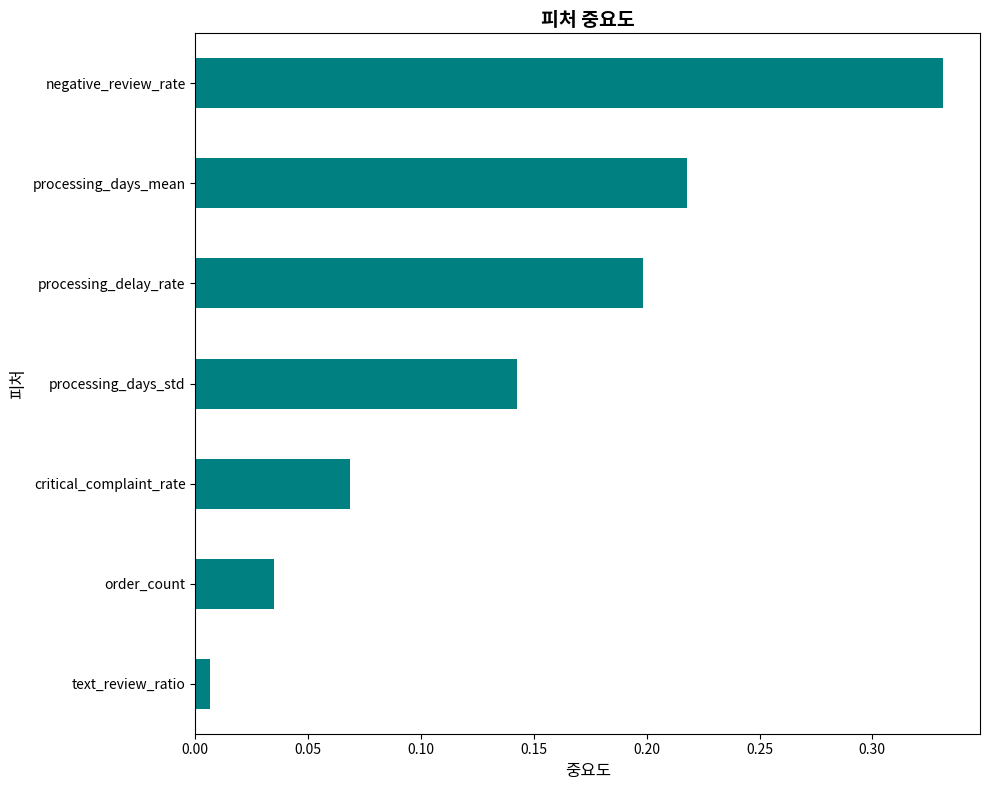

피처 중요도 Top 5
1. negative_review_rate: 0.3311
2. processing_days_mean: 0.2180
3. processing_delay_rate: 0.1985
4. processing_days_std: 0.1425
5. critical_complaint_rate: 0.0684


In [686]:
# 피처 중요도 추출
importances = pd.Series(model.feature_importances_, index=feature_7)
importances = importances.sort_values(ascending=True)

# 시각화
plt.figure(figsize=(10, 8))
importances.plot(kind='barh', color='teal')
plt.title('피처 중요도', fontsize=14, fontweight='bold')
plt.xlabel('중요도', fontsize=12)
plt.ylabel('피처', fontsize=12)
plt.tight_layout()
plt.show()

print("="*80)
print("피처 중요도 Top 5")
print("="*80)
for idx, (feat, imp) in enumerate(importances.sort_values(ascending=False).head(5).items(), 1):
    print(f"{idx}. {feat}: {imp:.4f}")
